# Replication - High Dimensional Case

Here we provide a notebook to replicate the simulation results for the high dimensional case simulation. 
As replicating all of the runs is rather time consuming, we provide this script to replicate a specified simulation run, which can then compared to the data provided on github.

The notebook replicates the results in:
- /out/simulation/sim_hd

The main script can be found at: 
- /scripts/simulation/highdimensional_case.py



## Please choose the settup for replication:

In [ ]:
run_id = 77 # any integer 1-200
suffix = 'rank50_b1024' # choose: rank5, rank50, rank50_b1024

In [ ]:
# google colab specific - installing probcox
!pip3 install torch==1.7.0
!pip3 install pyro-ppl==1.5.1
!pip3 install probcox

In [ ]:
# Modules
# =======================================================================================================================
import os
import sys
import shutil
import subprocess
import tqdm

import numpy as np
import pandas as pd

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor

np.random.seed(890)
torch.manual_seed(543)

In [ ]:
# Simulation Settings
# =======================================================================================================================
I = 1000 # Number of Individuals
P_binary = 5000
P_continuous = 5000
P = P_binary + P_continuous
theta = np.random.normal(0, 0.75, 20)[:, None]
theta = np.concatenate((theta[:10], np.zeros((4990, 1)), theta[10:], np.zeros((4990, 1))))
scale = 3  # Scaling factor for Baseline Hazard

In [ ]:

# Simulation 
# =======================================================================================================================
# Class for simulation
TVC = pcox.TVC(theta=theta, P_binary=P_binary, P_continuous=P_continuous, dtype=dtype)

# Sample baseline hazard - scale is set to define censorship/events
TVC.make_lambda0(scale=scale)

# Sample Data
np.random.seed(run_id)
torch.manual_seed(run_id)
surv = torch.zeros((0, 3))
X = torch.zeros((0, P))
for __ in tqdm.tqdm(range(I)):
    a, b = TVC.sample()
    surv = torch.cat((surv, a))
    X = torch.cat((X, b))

total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()


100%|██████████| 1000/1000 [01:04<00:00, 15.57it/s]


In [ ]:
# Inference Setup
# =======================================================================================================================
# Custom linear predictor - Here: simple linear combination
def predictor(data):
    theta =  pyro.sample("theta", dist.StudentT(1, loc=0, scale=0.001).expand([data[1].shape[1], 1])).type(dtype)
    pred = torch.mm(data[1], theta)
    return(pred)

def evaluate(surv, X, rank, batchsize, sampling_proportion, iter_, predictor=predictor):
    sampling_proportion[1] = batchsize
    eta=5 # paramter for optimization
    run = True # repeat initalization if NAN encounterd while training - gauge correct optimization settings
    while run:
        run = False
        pyro.clear_param_store()
        m = pcox.PCox(sampling_proportion=sampling_proportion, predictor=predictor)
        m.initialize(eta=eta, rank=rank, num_particles=5)
        loss=[0]
        for ii in tqdm.tqdm(range((iter_))):
            idx = np.unique(np.concatenate((np.random.choice(np.where(surv[:, -1]==1)[0], 1, replace=False), np.random.choice(range(surv.shape[0]), batchsize-1, replace=False)))) # random sample of data - force at least one event (no evaluation otherwise)
            data=[surv[idx], X[idx]] # subsampled data
            loss.append(m.infer(data=data))
            # divergence check
            if loss[-1] != loss[-1]:
                eta = eta * 0.1
                run=True
                break
    g = m.return_guide()
    out = g.quantiles([0.025, 0.5, 0.975])
    return(out)

In [ ]:
# Run
# =======================================================================================================================

if suffix == 'rank5':
    pyro.clear_param_store()
    out = evaluate(rank=5, batchsize=512, iter_=25000, surv=surv, X=X, sampling_proportion=[total_obs, None, total_events, None])
elif suffix == 'rank50':
    pyro.clear_param_store()
    out = evaluate(rank=50, batchsize=512, iter_=25000, surv=surv, X=X, sampling_proportion=[total_obs, None, total_events, None])
else:
    pyro.clear_param_store()
    out = evaluate(rank=50, batchsize=1024, iter_=25000, surv=surv, X=X, sampling_proportion=[total_obs, None, total_events, None])


100%|██████████| 25000/25000 [1:51:28<00:00,  3.74it/s]


In [ ]:

# Download data from github
# =======================================================================================================================

url1 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/probcox' + suffix +'_theta.txt'
url2 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/probcox' + suffix +'_theta_lower.txt'
url3 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/probcox' + suffix +'_theta_upper.txt'


theta_est_sim = pd.read_csv(url1, header=None, sep=';')
theta_est_lower_sim = pd.read_csv(url2, header=None, sep=';')
theta_est_upper_sim = pd.read_csv(url3, header=None, sep=';')


The estimates can vary to a certain degree - this is due to a numerical instability we observe for the prior distribution. 
Choosing a scale of lower then 0.01 for the studentT distribution makes it very difficult to get exact replications. 
However, the overall results are still valid and the replication provides very similar estimates. 

In [ ]:
# Comparision
# =======================================================================================================================

print('Mean Absolute Error - estmiate: ', np.mean(np.abs(np.squeeze(out['theta'][1].detach().numpy()) - np.squeeze(np.asarray(theta_est_sim.iloc[np.where(theta_est_sim.iloc[:, 0] == run_id)[0], 1:-1])))))

print('Mean Absolute Error - lower bound estmiate: ',np.mean(np.abs(np.squeeze(out['theta'][0].detach().numpy()) - np.squeeze(np.asarray(theta_est_lower_sim.iloc[np.where(theta_est_lower_sim.iloc[:, 0] == run_id)[0], 1:-1])))))

print('Mean Absolute Error - upper bound estmiate: ',np.mean(np.abs(np.squeeze(out['theta'][2].detach().numpy()) - np.squeeze(np.asarray(theta_est_upper_sim.iloc[np.where(theta_est_upper_sim.iloc[:, 0] == run_id)[0], 1:-1])))))

Mean Absolute Error - estmiate:  8.867434654783884e-05
Mean Absolute Error - lower bound estmiate:  0.00014202733582351318
Mean Absolute Error - upper bound estmiate:  0.00013879942063940517


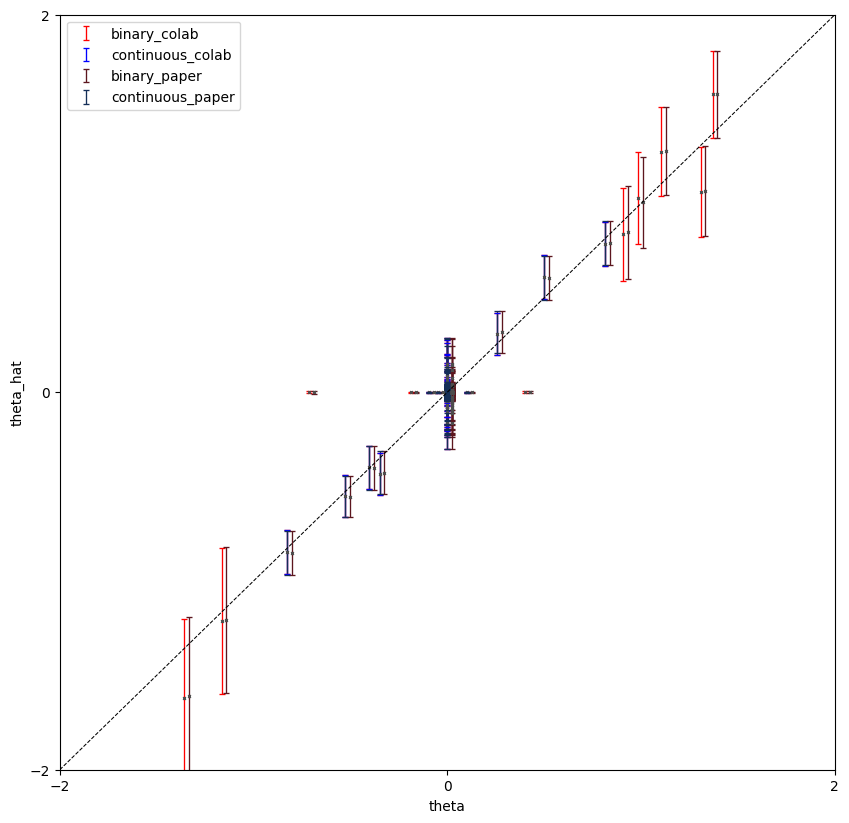

In [ ]:
# Comparision - Plot
# =======================================================================================================================

theta_est_sim = np.squeeze(np.asarray(theta_est_sim.iloc[np.where(theta_est_sim.iloc[:, 0] == run_id)[0], 1:-1]))[:, None]
theta_est_lower_sim = np.squeeze(np.asarray(theta_est_lower_sim.iloc[np.where(theta_est_lower_sim.iloc[:, 0] == run_id)[0], 1:-1]))[:, None]
theta_est_upper_sim = np.squeeze(np.asarray(theta_est_upper_sim.iloc[np.where(theta_est_upper_sim.iloc[:, 0] == run_id)[0], 1:-1]))[:, None]

theta_est = out['theta'][1].detach().numpy()
theta_est_lower = out['theta'][0].detach().numpy()
theta_est_upper = out['theta'][2].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)  
ax.errorbar(theta[:, 0], theta_est[:, 0], yerr=(theta_est[:, 0] - theta_est_lower[:, 0], theta_est_upper[:, 0]- theta_est[:, 0]),  ls='', c="red", capsize=2, capthick=0.95, elinewidth=0.95, label='binary_colab')
ax.errorbar(theta[5000:, 0], theta_est[5000:, 0], yerr=(theta_est[5000:, 0] - theta_est_lower[5000:, 0], theta_est_upper[5000:, 0]- theta_est[5000:, 0]),  ls='', c="blue", capsize=2, capthick=0.95, elinewidth=0.95, label='continuous_colab')

ax.plot(theta[:, 0], theta_est[:, 0], ls='', c=".3", marker='x', ms=2)
ax.errorbar(theta[:, 0]+0.025, theta_est_sim[:, 0], yerr=(theta_est_sim[:, 0] - theta_est_lower_sim[:, 0], theta_est_upper_sim[:, 0]- theta_est_sim[:, 0]),  ls='', c="#5c161e", capsize=2, capthick=0.95, elinewidth=0.95, label='binary_paper')
ax.errorbar(theta[5000:, 0], theta_est_sim[5000:, 0], yerr=(theta_est_sim[5000:, 0] - theta_est_lower_sim[5000:, 0], theta_est_upper_sim[5000:, 0]- theta_est_sim[5000:, 0]),  ls='', c="#142e57", capsize=2, capthick=0.95, elinewidth=0.95, label='continuous_paper')
ax.plot(theta[:, 0]+0.025, theta_est_sim[:, 0], ls='', c=".3", marker='x', ms=2)

ax.set(xlim=(-2, 2), ylim=(-2, 2))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="black", linewidth=0.75)
ax.set_yticks([-2, 0, 2])
ax.set_ylim([-2, 2])
ax.set_xticks([-2, 0, 2])
ax.set_xlim([-2, 2])
ax.set_xlabel('theta')
ax.set_ylabel('theta_hat')
plt.legend()
plt.show()
plt.close()

# R evaluation

In [ ]:
# prepare data frame to sent to R
rd = pd.DataFrame(np.concatenate((surv.numpy(), X.numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]

In [ ]:
# load R 
%load_ext rpy2.ipython

In [ ]:
# install packages
%%R 
install.packages('survival')
install.packages('glmnet')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survival_3.2-11.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 6274168 bytes (6.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [ ]:
%%R -i rd -o r_lasso_coef -o r_lasso_coef_1se -o r_Alasso1_coef -o r_Alasso1_coef_1se -o r_Alasso2_coef -o r_Alasso2_coef_1se

set.seed(13)
library(glmnet)
library(survival)
#library(doMC)

#registerDoMC(cores = 3)

yss = Surv(rd$V1, rd$V2, rd$V3)

cv.fit <-cv.glmnet(as.matrix(rd[, 4:10003]), yss, family ="cox", nfolds=3, parallel=FALSE, type.measure ="C", lambda=seq(0.01, 0.02, 0.0015))
m <- glmnet(as.matrix(rd[, 4:10003]), yss, family ="cox", lambda=cv.fit$lambda.min)
r_coef <- as.matrix(unname(coef(m)))

m <- glmnet(as.matrix(rd[, 4:10003]), yss, family ="cox", lambda=cv.fit$lambda.1se)
r_coef_1se <- as.matrix(unname(coef(m)))

    
    # Lasso 
    cv.fit <- c()
    cv.fit <- cv.glmnet(as.matrix(rd[, 4:10003]), yss, family ="cox", nfolds=5, parallel=TRUE, type.measure ="C", alpha=1)

    r_lasso_coef = as.matrix(unname(coef(cv.fit, s=cv.fit$lambda.min)))
    r_lasso_coef_1se = as.matrix(unname(coef(cv.fit, s=cv.fit$lambda.1se)))

    w1 <- 1/abs(as.numeric(coef(cv.fit, s=cv.fit$lambda.min)))
    w1[w1 == Inf] <- 1000000 
    
    w2 <- 1/abs(as.numeric(coef(cv.fit, s=cv.fit$lambda.1se)))
    w2[w2 == Inf] <- 1000000 
    
    # Ridge 
    #cv.fit <- c()
    #cv.fit <- cv.glmnet(as.matrix(sim[, 4:10003]), yss, family ="cox", nfolds=5, parallel=TRUE, type.measure ="C", alpha=0)
    #x = paste(sim_name, paste(unname(coef(cv.fit, s=cv.fit$lambda.min)), collapse="; "), sep='; ')
    #write(x, file = paste(ROOT_DIR, '/out/simulation/sim_hd/R_ridge_theta.txt', sep=''), ncolumns = 1, append = TRUE, sep = ";")
    #x = paste(sim_name, paste(unname(coef(cv.fit, s=cv.fit$lambda.1se)), collapse="; "), sep='; ')
    #write(x, file = paste(ROOT_DIR, '/out/simulation/sim_hd/R_ridge_theta_1se.txt', sep=''), ncolumns = 1, append = TRUE, sep = ";")
    
    #w3 <- 1/abs(as.numeric(coef(cv.fit, s=cv.fit$lambda.min)))
    #w3[w3 == Inf] <- 1000000 
    
    #w4 <- 1/abs(as.numeric(coef(cv.fit, s=cv.fit$lambda.1se)))
    #w4[w4 == Inf] <- 1000000 
   
    # Adaptive Lasso
    # Alasso 
    cv.fit <- c()
    cv.fit <-cv.glmnet(as.matrix(rd[, 4:10003]), yss, family ="cox", nfolds=5, parallel=TRUE, type.measure="C", penalty.factor=w1)
    r_Alasso1_coef = as.matrix(unname(coef(cv.fit, s=cv.fit$lambda.min)))
    r_Alasso1_coef_1se = as.matrix(unname(coef(cv.fit, s=cv.fit$lambda.1se)))

    # Alasso 2
    cv.fit <- c()
    cv.fit <-cv.glmnet(as.matrix(rd[, 4:10003]), yss, family ="cox", nfolds=5, parallel=TRUE, type.measure="C", penalty.factor=w2)
    r_Alasso2_coef = as.matrix(unname(coef(cv.fit, s=cv.fit$lambda.min)))
    r_Alasso2_coef_1se = as.matrix(unname(coef(cv.fit, s=cv.fit$lambda.1se)))

    # Alasso 3
    #cv.fit <- c()
    #cv.fit <-cv.glmnet(as.matrix(sim[, 4:10003]), yss, family ="cox", nfolds=5, parallel=TRUE, type.measure="C", penalty.factor=w3)
    #x = paste(sim_name, paste(unname(coef(cv.fit, s=cv.fit$lambda.min)), collapse="; "), sep='; ')
    #write(x, file = paste(ROOT_DIR, '/out/simulation/sim_hd/R_Alasso3_theta.txt', sep=''), ncolumns = 1, append = TRUE, sep = ";")
    #x = paste(sim_name, paste(unname(coef(cv.fit, s=cv.fit$lambda.1se)), collapse="; "), sep='; ')
    #write(x, file = paste(ROOT_DIR, '/out/simulation/sim_hd/R_Alasso3_theta_1se.txt', sep=''), ncolumns = 1, append = TRUE, sep = ";")
    
    # Alasso 4
    #cv.fit <- c()
    #cv.fit <-cv.glmnet(as.matrix(sim[, 4:10003]), yss, family ="cox", nfolds=5, parallel=TRUE, type.measure="C", penalty.factor=w4)
    #x = paste(sim_name, paste(unname(coef(cv.fit, s=cv.fit$lambda.min)), collapse="; "), sep='; ')
    #write(x, file = paste(ROOT_DIR, '/out/simulation/sim_hd/R_Alasso4_theta.txt', sep=''), ncolumns = 1, append = TRUE, sep = ";")
    #x = paste(sim_name, paste(unname(coef(cv.fit, s=cv.fit$lambda.1se)), collapse="; "), sep='; ')
    #write(x, file = paste(ROOT_DIR, '/out/simulation/sim_hd/R_Alasso4_theta_1se.txt', sep=''), ncolumns = 1, append = TRUE, sep = ";")

R[write to console]: Loading required package: Matrix

R[write to console]: Loaded glmnet 4.1-1



In [ ]:

# Download data from github
# =======================================================================================================================
url1 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/R_lasso_theta.txt'
url2 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/R_lasso_theta_1se.txt'
theta_R_lasso = pd.read_csv(url1, header=None, sep=';')
theta1se_R_lasso = pd.read_csv(url2, header=None, sep=';')


url1 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/R_Alasso1_theta.txt'
url2 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/R_Alasso1_theta_1se.txt'
theta_R_Alasso1 = pd.read_csv(url1, header=None, sep=';')
theta1se_R_Alasso1 = pd.read_csv(url2, header=None, sep=';')


url1 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/R_Alasso2_theta.txt'
url2 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd/R_Alasso2_theta_1se.txt'
theta_R_Alasso2 = pd.read_csv(url1, header=None, sep=';')
theta1se_R_Alasso2 = pd.read_csv(url2, header=None, sep=';')


In [ ]:
# Comparision
# =======================================================================================================================
print('Lasso')
print('Mean Absolute Error - lambda min: ', np.mean(np.abs(r_lasso_coef[:, 0] - np.squeeze(np.asarray(theta_R_lasso.iloc[np.where(theta_R_lasso.iloc[:, 0] == run_id)[0], 1:])))))
print('Mean Absolute Error - lambda 1se: ',np.mean(np.abs(r_lasso_coef_1se[:, 0] - np.squeeze(np.asarray(theta1se_R_lasso.iloc[np.where(theta1se_R_lasso.iloc[:, 0] == run_id)[0], 1:])))))

print('Alasso1')
print('Mean Absolute Error - lambda min: ', np.mean(np.abs(r_Alasso1_coef[:, 0] - np.squeeze(np.asarray(theta_R_Alasso1.iloc[np.where(theta_R_Alasso1.iloc[:, 0] == run_id)[0], 1:])))))
print('Mean Absolute Error - lambda 1se: ',np.mean(np.abs(r_Alasso1_coef_1se[:, 0] - np.squeeze(np.asarray(theta1se_R_Alasso1.iloc[np.where(theta1se_R_Alasso1.iloc[:, 0] == run_id)[0], 1:])))))


print('Alasso2')
print('Mean Absolute Error - lambda min: ', np.mean(np.abs(r_Alasso2_coef[:, 0] - np.squeeze(np.asarray(theta_R_Alasso2.iloc[np.where(theta_R_Alasso2.iloc[:, 0] == run_id)[0], 1:])))))
print('Mean Absolute Error - lambda 1se: ',np.mean(np.abs(r_Alasso2_coef_1se[:, 0] - np.squeeze(np.asarray(theta1se_R_Alasso2.iloc[np.where(theta1se_R_Alasso2.iloc[:, 0] == run_id)[0], 1:])))))


Mean Absolute Error - lambda min:  1.4442667280439164e-12
Mean Absolute Error - lambda 1se:  1.0890139637287355e-12
